In [1]:
#@title Imports

import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from typing import Tuple, Optional
import math
from torch import Tensor
from einops import rearrange
from diffusers import DDPMScheduler, UNet2DModel
from torchvision import datasets, transforms
import numpy as np
from sklearn.cluster import KMeans
from PIL import Image
import os
from tqdm import tqdm
from scipy.spatial import KDTree
import torch.nn.functional as F


c:\Users\Shlomi\AppData\Local\pypoetry\Cache\virtualenvs\text-conditioned-image-generation-using-st-35DVCAXA-py3.11\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


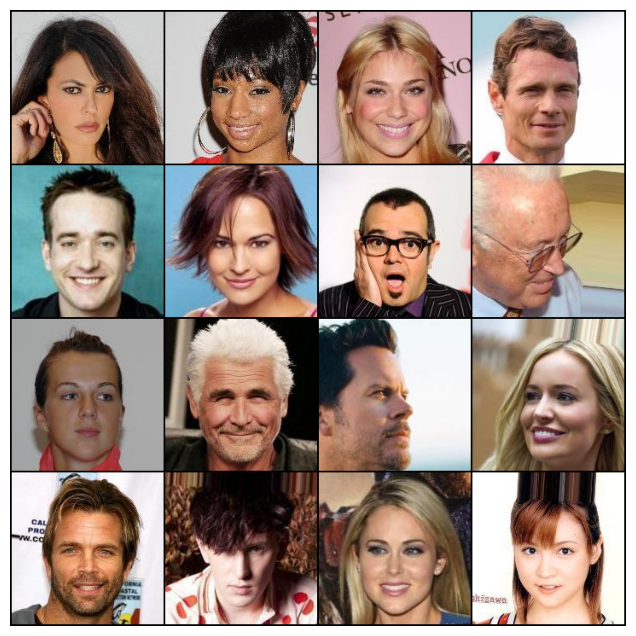

In [2]:
# Define the path to where you saved the dataset

data_root = r"celeba/"

# Define transforms (resizing, tensor conversion, normalization)
transform = transforms.Compose([
    transforms.CenterCrop(178),  # Original images are 178x218
    # transforms.Resize(64),       # Resize to 64x64 if you want a small version
    transforms.ToTensor(),
    # transforms.Normalize([0.5]*3, [0.5]*3)  # Normalize to [-1, 1]
])

# Load the dataset
celeba_dataset = datasets.CelebA(
    root=data_root,
    split="train",            # 'train', 'valid', 'test', or 'all'
    target_type="attr",       # 'attr', 'identity', 'bbox', 'landmarks'
    transform=transform,
    download=True            # You've already downloaded it
)

# Create a DataLoader
dataloader = DataLoader(celeba_dataset, batch_size=64, shuffle=True)

# Show an example batch
images, attributes = next(iter(dataloader))
grid = torchvision.utils.make_grid(images[:16], nrow=4, normalize=False)
plt.figure(figsize=(8,8))
plt.imshow(grid.permute(1, 2, 0))  # CHW to HWC
plt.axis('off')
plt.show()  

In [ ]:
def collect_pixels(dataloader, max_samples=1_000_000):
    collected = []
    total_pixels = 0
    with torch.no_grad():
        for images, attr in tqdm(dataloader):
            pixels = images.permute(0, 2, 3, 1).reshape(-1, 3)  # [N, 3], where N = H*W
            collected.append(pixels)
            total_pixels += torch.sum(pixels)
            if total_pixels > max_samples:
                break
    all_pixels = torch.cat(collected, dim=0)
    idx = torch.randperm(all_pixels.shape[0])[:max_samples]
    return all_pixels[idx] * 255  # Convert to 0–255

In [4]:
print('a')
pixels = collect_pixels(dataloader)
print('b')

X = 8  # e.g. 5 bits => 32 colors
K = 2 ** X

kmeans = KMeans(n_clusters=K, random_state=42)
kmeans.fit(pixels.numpy())
palette = torch.tensor(kmeans.cluster_centers_, dtype=torch.uint8)  # shape [K, 3]

a


  0%|          | 0/2544 [00:00<?, ?it/s]

  0%|          | 0/2544 [00:14<?, ?it/s]


RuntimeError: Boolean value of Tensor with more than one value is ambiguous

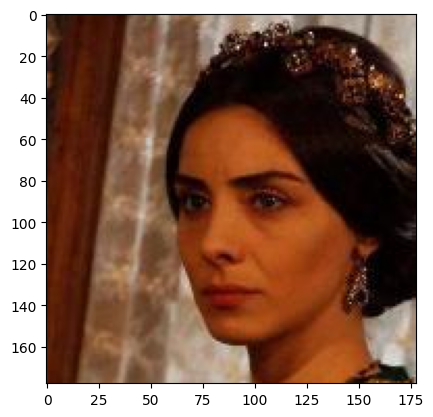

In [47]:
def map_image_to_palette_indices(image_tensor, palette):
    """
    image_tensor: [3, H, W], float32 in [0,1]
    palette: [K, 3], uint8
    """
    image = (image_tensor.permute(1, 2, 0) * 255).reshape(-1, 3)  # [H*W, 3]
    dists = torch.cdist(image.float(), palette.float())  # [H*W, K]
    indices = dists.argmin(dim=1)
    return indices.reshape(image_tensor.shape[1:])  # [H, W], each pixel is an index

def reconstruct_image_from_indices(indices, palette):
    """
    indices: [H, W]
    palette: [K, 3], uint8
    returns: [3, H, W], float32 in [0,1]
    """
    h, w = indices.shape
    flat = palette[indices.view(-1)].reshape(h, w, 3)
    return flat.permute(2, 0, 1).float() / 255

# Plot single image
x, _ = next(iter(dataloader))
x = x[0]

plt.imshow(rearrange(x, "c h w -> h w c"))